In [3]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2025-11-12 08:09:12,552 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2025-11-12 08:09:12,558 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type


In [ ]:
dataset.head(5)

,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,0.085267,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,0.399684,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,0.358029,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,0.286687,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,0.043190,1.5,0.832614,wheat,0.555076


Let's take a quick look at our dataset to ensure it imported correctly.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt

Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data are still as we expect it to be.

In [5]:
# Validate the data
# !pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)



import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

Deleted sampled_field_df.csv


To begin our exploration of the dataset, we will use a decision tree to explore how all of the variables affect our crop yields.

Given our dataset containing information on environmental factors and crop yields, how can we train a decision tree model to predict crop yields accurately?

Fit a decision tree regressor model to the entire dataset.

Use all predictor variables (excluding non-numeric columns) to predict `Standard_yield`.

Set the `max_depth` to 4 and the `random_state` to 42 for reproducibility.

Considering the **MSE** and **R²** values, how effective is the decision tree in predicting crop yields using all of our variables?

In [6]:
Non_numeric = ['Location', 'Soil_type', 'Crop_type']

# Define variables selecting only the numeric column for the x variables
X=dataset.drop(columns=['Standard_yield']+Non_numeric)
y=dataset['Standard_yield']

# Convert X to a numpy array and then reshape it to add a new axis
# set test size to 30 % of training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)

# Fit the model to the entire dataset
tree_model.fit(X, y)

# Predict the target variable using the trained model
y_pred = tree_model.predict(x_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.0077
R-squared (R²): 0.4018


MSE is very low: predictions are close to actual values in absolute terms.

R² is moderate: although the predictions are close on average, there’s still substantial variance in the target that the model doesn’t explain



While the model shows some predictive capability with a moderate R² value, there is still room for improvement, particularly in reducing the MSE and potentially increasing the explanatory power of the model. This can be achieved through further feature selection, hyperparameter tuning, or exploring alternative modelling techniques.

Let's start with feature selection. What environmental factors have the highest correlation with crop yields, and how can we use this information to improve the predictive performance of our model?

Conduct feature selection using a **correlation matrix** to select relevant features for predicting `Standard_yield`.

Visualise the matrix to better identify the features with the highest correlation with `Standard_yield`.

Regarding features to retain and eliminate, what do the results suggest? Have you thought about the independent features that might be correlated?


Correlation with Standard_yield:
 Standard_yield       1.000000
Annual_yield         0.220812
Min_temperature_C    0.144233
Elevation            0.129248
Longitude            0.085343
Soil_fertility       0.070205
Latitude             0.061724
Slope                0.056991
Rainfall             0.039217
Field_ID             0.030802
Ave_temps            0.006786
Plot_size           -0.017014
Max_temperature_C   -0.111649
pH                  -0.196613
Pollution_level     -0.285761
Name: Standard_yield, dtype: float64


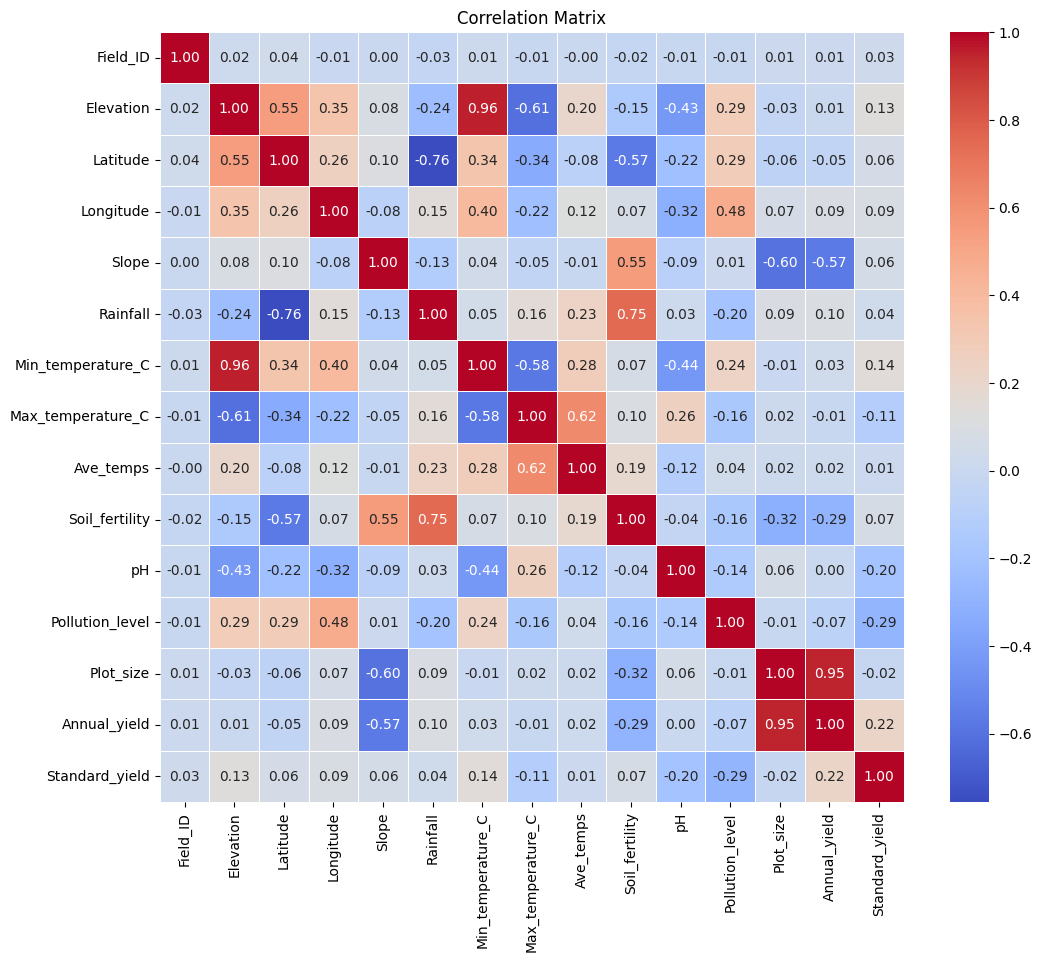

In [8]:
# 1. Correlation Analysis
non_numeric_dataset = dataset.drop(columns = ['Location', 'Soil_type', 'Crop_type'])
correlation_matrix = non_numeric_dataset.corr()
print("Correlation with Standard_yield:\n", correlation_matrix['Standard_yield'].sort_values(ascending=False))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Now that we know which features could work best for our model, let's run our model again on a reduced dataset.

Reduce the dataset to only include `Pollution_level`, `Min_temperature_C`, `Longitude`, and `pH`.

Refit the decision tree regressor model using the reduced dataset and evaluate the model's performance on the test set to determine if there's an improvement in MSE and R² values.

Does reducing the dataset lead to an improvement in the predictive performance of our model?

Run the model on different combinations of the reduced dataset. Is there a combination of variables or a single variable that improves the MSE and R²?

In [9]:
# Reduce the dataset to five columns
reduced_dataset=dataset[['Pollution_level','Min_temperature_C','Longitude','pH','Standard_yield']]
X=reduced_dataset.drop(columns=['Standard_yield'])
y=reduced_dataset['Standard_yield']

# set test size to 30 % of training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)

# Fit the model to the entire dataset
tree_model.fit(X, y)

# Predict the target variable using the trained model
y_pred = tree_model.predict(x_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Mean Squared Error (MSE): 0.0084
R-squared (R²): 0.3477


The changes are modest, suggesting that:

The variables you removed contributed some useful information, but not dramatically so.

The simpler model (with fewer predictors) still performs comparably well — which is good for interpretability and reduces overfitting risk.

The model's performance has not improved. The MSE has increased and the R-squared value has decreased. This indicates that using only the selected features has led to a worse predictive performance compared to the previous model. This illustrates the cost of simplified models – we're losing predictive ability whilst gaining ease of interpretation. It's also worth remembering that the R-squared value generally increases as more variables are added – which shouldn't tempt us to do so without good reason!


Now that we have attempted feature engineering, let's move on to parameter tuning. What is the optimal depth for the decision tree model that maximises predictive performance while avoiding overfitting?

Use a loop to fit decision tree models with depths ranging from 1 to 10 and assess the MSE and R² scores for each depth.
Analyse the results to identify the depth that maximises R² while avoiding significant increases in MSE, indicating optimal model complexity.

In [11]:
# Define a range of depths to try
depths_to_try = range(1, 11)

# Initialise empty lists to store results
mse_scores = []
r2_scores = []

# Iterate over depths and fit models
for depth in depths_to_try:
    # Train the model
    model = DecisionTreeRegressor(max_depth=depth, random_state=42).fit(x_train, y_train)
    predictions = model.predict(x_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Append scores to lists
    mse_scores.append(mse)
    r2_scores.append(r2)

# Print the results
for depth, mse, r2 in zip(depths_to_try, mse_scores, r2_scores):
    print(f"Depth: {depth}, MSE: {mse}, R2: {r2}")

Depth: 1, MSE: 0.011346751164118245, R2: 0.11791975137262489
Depth: 2, MSE: 0.009765370470906087, R2: 0.24085403052155063
Depth: 3, MSE: 0.00902979208907587, R2: 0.2980368445751046
Depth: 4, MSE: 0.008844274351502885, R2: 0.3124587288410299
Depth: 5, MSE: 0.00866221343822956, R2: 0.32661188451728207
Depth: 6, MSE: 0.008533708422990784, R2: 0.33660168108126565
Depth: 7, MSE: 0.00894024607176622, R2: 0.30499802421759703
Depth: 8, MSE: 0.009677506334365895, R2: 0.2476844631523366
Depth: 9, MSE: 0.00976898927915278, R2: 0.2405727095309158
Depth: 10, MSE: 0.01027240093112741, R2: 0.20143820585554528


As the depth of the decision tree increases, the MSE generally decreases initially until reaching a minimum at depth 6. Beyond that, the MSE starts to increase again.

The R-squared values also show a similar trend to MSE, initially increasing until depth 6 is reached, and then slightly decreasing afterwards.

Depth 6 seems to provide the best balance between model complexity and performance, as it has the lowest MSE among depths 1 to 5 and a relatively high R² value compared to other depths.

Beyond depth 6, increasing the depth of the decision tree leads to overfitting, as indicated by the increasing MSE and decreasing R-squared values. This means the model starts capturing noise in the data rather than true patterns, resulting in poorer performance on unseen data.

As a final piece of testing (see it as a reward), select only the cassava crops and fit a decision tree to it. Tip: add in the Rainfall variable.

In [13]:
# select only casssava crops
selected_cassava=dataset.loc[dataset['Crop_type'] == 'cassava', ['Standard_yield', 'Rainfall', 'Pollution_level','Min_temperature_C','Longitude','pH',]]

# define variables
X=selected_cassava.drop(columns=['Standard_yield'])
y=selected_cassava['Standard_yield']

# set test size to 30 % of training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)

# Fit the model to the entire dataset
tree_model.fit(X, y)

# Predict the target variable using the trained model
y_pred = tree_model.predict(x_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0003
R-squared (R²): 0.9515


The R-squared value is significantly higher than we had for our model. This suggests that we might need to break down the model into decision trees for each crop or use dummy variables when creating it. Sometimes it's useful to approach the same data from different angles, as a fitted model can probably always be improved!